In [1]:
pip install pyodbc

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip show sqlalchemy

Name: SQLAlchemyNote: you may need to restart the kernel to use updated packages.

Version: 1.4.39
Summary: Database Abstraction Library
Home-page: https://www.sqlalchemy.org
Author: Mike Bayer
Author-email: mike_mp@zzzcomputing.com
License: MIT
Location: C:\Users\jg3wi\anaconda3\Lib\site-packages
Requires: greenlet
Required-by: 


In [3]:
from sqlalchemy import create_engine, select, Table, MetaData, func, case, text, desc, literal_column, cast, Float, inspect
from sqlalchemy.sql.expression import over
from tabulate import tabulate
from decimal import Decimal
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt




engine = create_engine("mssql+pyodbc://localhost/AdventureWorks2022?driver=ODBC+Driver+17+for+SQL+Server")
#Anslut till den lokala databasen
metadata = MetaData()
metadata.reflect(bind=engine)

In [4]:
#Kolla så att jag är ansluten
with engine.connect() as conn:
    result = conn.execute("SELECT 1")
    print(result.fetchone())

(1,)


In [18]:
#Löner för olika positioner + medelön
metadata = MetaData()
metadata.reflect(bind=engine, schema="Person")
metadata.reflect(bind=engine, schema="HumanResources")

person = metadata.tables["Person.Person"]
employee = metadata.tables["HumanResources.Employee"]
pay_history = metadata.tables["HumanResources.EmployeePayHistory"]

query = select(
    person.c.FirstName,
    person.c.LastName,
    employee.c.JobTitle,
    cast(pay_history.c.Rate, Float).label("Rate")
).select_from(
    person
    .outerjoin(employee, person.c.BusinessEntityID == employee.c.BusinessEntityID)
    .outerjoin(pay_history, person.c.BusinessEntityID == pay_history.c.BusinessEntityID)
).where(
    pay_history.c.Rate.isnot(None)
).order_by(pay_history.c.Rate.desc())

with engine.connect() as conn:
    result = conn.execute(query).fetchall()

data = [dict(row._mapping) for row in result]

unique_employees = {}

for row in data:
    key = (row["FirstName"], row["LastName"], row["JobTitle"]) 
    if key not in unique_employees or row["Rate"] > unique_employees[key]["Rate"]:
        unique_employees[key] = row 

filtered_data = list(unique_employees.values())

pay_rates = [row["Rate"] for row in filtered_data] 

average_pay = sum(pay_rates) / len(pay_rates) if pay_rates else 0 

print(f"Average Pay: {average_pay:.2f}")

print(tabulate(filtered_data, headers="keys", tablefmt="grid"))




C:\Users\jg3wi\AppData\Local\Temp\ipykernel_15120\4272108867.py:3: SAWarning: Did not recognize type 'geography' of column 'SpatialLocation'
  metadata.reflect(bind=engine, schema="Person")
C:\Users\jg3wi\AppData\Local\Temp\ipykernel_15120\4272108867.py:4: SAWarning: Did not recognize type 'hierarchyid' of column 'OrganizationNode'
  metadata.reflect(bind=engine, schema="HumanResources")


Average Pay: 18.19
+-------------+-------------------+------------------------------------------+----------+
| FirstName   | LastName          | JobTitle                                 |     Rate |
+=============+===================+==========================================+==========+
| Ken         | Sánchez           | Chief Executive Officer                  | 125.5    |
+-------------+-------------------+------------------------------------------+----------+
| James       | Hamilton          | Vice President of Production             |  84.1346 |
+-------------+-------------------+------------------------------------------+----------+
| Brian       | Welcker           | Vice President of Sales                  |  72.1154 |
+-------------+-------------------+------------------------------------------+----------+
| Terri       | Duffy             | Vice President of Engineering            |  63.4615 |
+-------------+-------------------+------------------------------------------+---

In [6]:
#Antal anställda
query = select(
    func.count(employee.c.BusinessEntityID).label("Total Employees") 
)

with engine.connect() as conn:
    result = conn.execute(query).fetchall()

data = [dict(row._mapping) for row in result]

print(tabulate(data, headers="keys", tablefmt="grid"))

+-------------------+
|   Total Employees |
+===================+
|               290 |
+-------------------+


In [7]:
#Ålder när det blev anställda
age_time_of_hire = (func.year(employee.c.HireDate) - func.year(employee.c.BirthDate)).label("AgeTimeofHire")

query = select(
    person.c.FirstName,
    person.c.LastName,
    employee.c.BirthDate,
    employee.c.HireDate,
    age_time_of_hire
).join(person, employee.c.BusinessEntityID == person.c.BusinessEntityID) 

with engine.connect() as conn:
    result = conn.execute(query).fetchall()

data = [dict(row._mapping) for row in result] 

print(tabulate(data, headers="keys", tablefmt="grid"))

+-------------+-------------------+-------------+------------+-----------------+
| FirstName   | LastName          | BirthDate   | HireDate   |   AgeTimeofHire |
+=============+===================+=============+============+=================+
| Ken         | Sánchez           | 1969-01-29  | 2009-01-14 |              40 |
+-------------+-------------------+-------------+------------+-----------------+
| Terri       | Duffy             | 1971-08-01  | 2008-01-31 |              37 |
+-------------+-------------------+-------------+------------+-----------------+
| Roberto     | Tamburello        | 1974-11-12  | 2007-11-11 |              33 |
+-------------+-------------------+-------------+------------+-----------------+
| Rob         | Walters           | 1974-12-23  | 2007-12-05 |              33 |
+-------------+-------------------+-------------+------------+-----------------+
| Gail        | Erickson          | 1952-09-27  | 2008-01-06 |              56 |
+-------------+-------------

In [8]:
#Medelåldern när de blev anställda
age_at_hire_expr = func.datediff(text('YEAR'), employee.c.BirthDate, employee.c.HireDate)

avg_age_query = select(func.avg(age_at_hire_expr).label("Average Age at Hire"))

with engine.connect() as conn:
    avg_age_result = conn.execute(avg_age_query).fetchone()

avg_age_data = [{"Average Age at Hire": round(avg_age_result[0], 2)}] if avg_age_result else [{"Average Age at Hire": "N/A"}]

print(tabulate(avg_age_data, headers="keys", tablefmt="grid"))

+-----------------------+
|   Average Age at Hire |
+=======================+
|                    31 |
+-----------------------+


In [9]:
#Ålder på de som arbetar, medelålder, lägsta och högsta.
employee = Table("Employee", metadata, autoload_with=engine, schema="HumanResources")

query = select(
    employee.c.JobTitle,
    func.concat(text("'avg: '"), func.avg(text("DATEDIFF(YEAR, BirthDate, GETDATE())"))).label("AVG_AGE"),
    func.concat(text("'min: '"), func.min(text("DATEDIFF(YEAR, BirthDate, GETDATE())"))).label("MIN_AGE"),
    func.concat(text("'max: '"), func.max(text("DATEDIFF(YEAR, BirthDate, GETDATE())"))).label("MAX_AGE")
).group_by(
    employee.c.JobTitle
).order_by(
    desc("AVG_AGE")
)

with engine.connect() as conn:
    result = conn.execute(query).fetchall()
    
data = [dict(row._mapping) for row in result] 

print(tabulate(data, headers="keys", tablefmt="grid"))

+------------------------------------------+-----------+-----------+-----------+
| JobTitle                                 | AVG_AGE   | MIN_AGE   | MAX_AGE   |
+==========================================+===========+===========+===========+
| North American Sales Manager             | avg: 74   | min: 74   | max: 74   |
+------------------------------------------+-----------+-----------+-----------+
| Production Supervisor - WC60             | avg: 69   | min: 69   | max: 69   |
+------------------------------------------+-----------+-----------+-----------+
| European Sales Manager                   | avg: 68   | min: 68   | max: 68   |
+------------------------------------------+-----------+-----------+-----------+
| Design Engineer                          | avg: 67   | min: 64   | max: 73   |
+------------------------------------------+-----------+-----------+-----------+
| Assistant to the Chief Financial Officer | avg: 61   | min: 61   | max: 61   |
+---------------------------

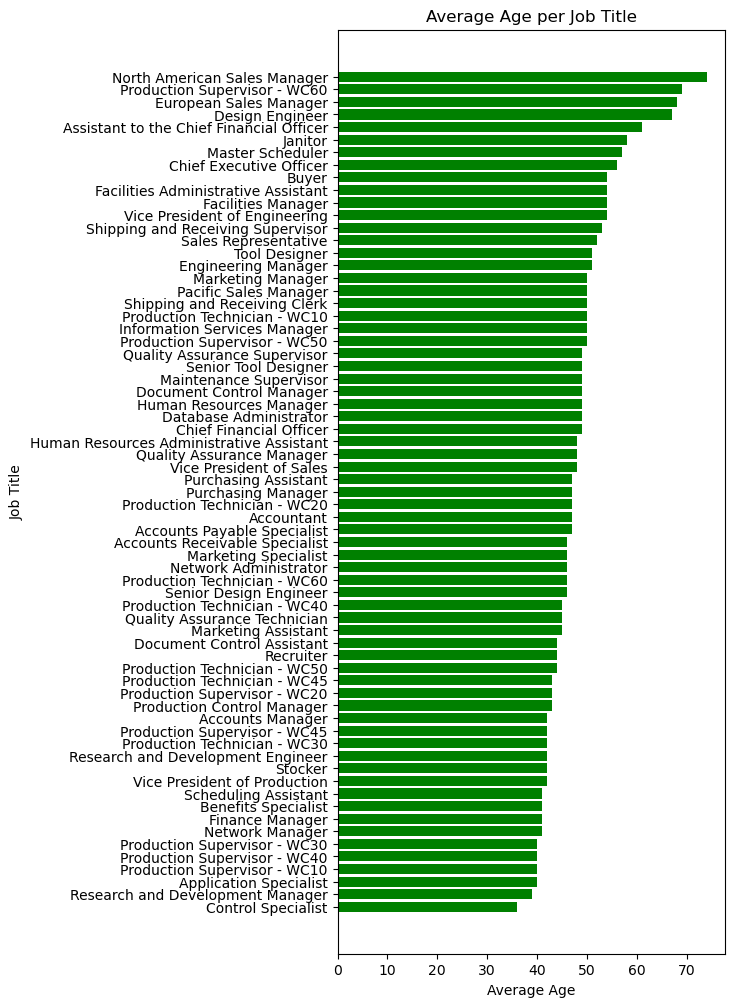

In [10]:
#Skapa diagram

job_titles = [row["JobTitle"] for row in data]
avg_ages = [float(row["AVG_AGE"].replace("avg: ", "")) for row in data]

plt.figure(figsize=(5, 12))
plt.barh(job_titles, avg_ages, color="green")
plt.xlabel("Average Age")
plt.ylabel("Job Title")
plt.title("Average Age per Job Title")
plt.gca().invert_yaxis()

plt.show()


In [11]:
#Hur lång tid arbetarna stannar på företaget.
employee_department = metadata.tables["HumanResources.EmployeeDepartmentHistory"]
employee = metadata.tables["HumanResources.Employee"]
retention_years = case(
    [(employee_department.c.EndDate.is_(None), 
      text("DATEDIFF(YEAR, StartDate, GETDATE())"))],
    else_=text("DATEDIFF(YEAR, StartDate, EndDate)") 
)

query = select(
    employee.c.JobTitle.label("Job Title"),
    func.avg(retention_years).label("AVG Retention Years") 
).select_from(
    employee_department
    .join(employee, employee_department.c.BusinessEntityID == employee.c.BusinessEntityID) 
).group_by(
    employee.c.JobTitle
).order_by(
    desc("AVG Retention Years") 
)

with engine.connect() as conn:
    result = conn.execute(query).fetchall()

data = [dict(row._mapping) for row in result] 

print(tabulate(data, headers="keys", tablefmt="grid"))


+------------------------------------------+-----------------------+
| Job Title                                |   AVG Retention Years |
+==========================================+=======================+
| Engineering Manager                      |                    18 |
+------------------------------------------+-----------------------+
| Benefits Specialist                      |                    17 |
+------------------------------------------+-----------------------+
| Finance Manager                          |                    17 |
+------------------------------------------+-----------------------+
| Human Resources Manager                  |                    17 |
+------------------------------------------+-----------------------+
| Information Services Manager             |                    17 |
+------------------------------------------+-----------------------+
| Master Scheduler                         |                    17 |
+---------------------------------

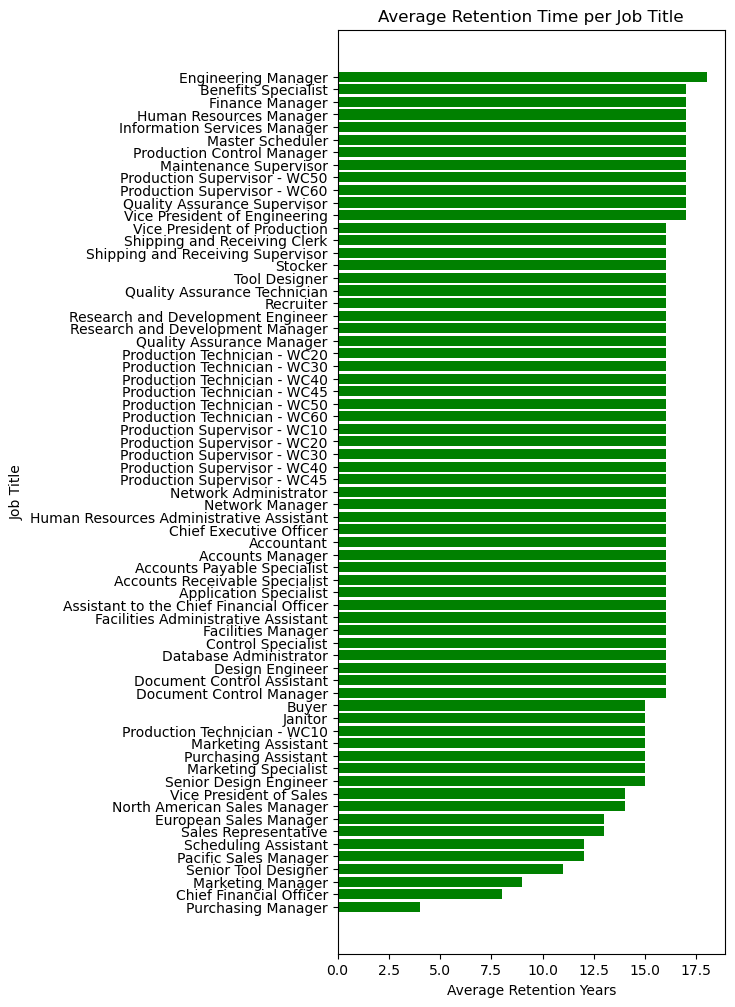

In [12]:
#Diagram
job_titles = [row["Job Title"] for row in data]
avg_retention = [float(row["AVG Retention Years"]) for row in data]

plt.figure(figsize=(5, 12))
plt.barh(job_titles, avg_retention, color="green")
plt.xlabel("Average Retention Years")
plt.ylabel("Job Title")
plt.title("Average Retention Time per Job Title")
plt.gca().invert_yaxis()
plt.show()

In [13]:
#Produkterna som get bäst vinstmarginal
product = Table("Product", metadata, autoload_with=engine, schema="Production")

query = select(
    product.c.Name.label("Product Name"),
    cast(product.c.StandardCost, Float).label("Cost"),
    cast(product.c.ListPrice, Float).label("Selling Price"),
    cast((product.c.ListPrice - product.c.StandardCost), Float).label("Profit")
).distinct().order_by(desc("Profit")) 

with engine.connect() as conn:
    result = conn.execute(query).fetchall()

data = [dict(row._mapping) for row in result] 

print(tabulate(data, headers="keys", tablefmt="grid"))

+----------------------------------+-----------+-----------------+-----------+
| Product Name                     |      Cost |   Selling Price |    Profit |
+==================================+===========+=================+===========+
| Mountain-100 Silver, 38          | 1912.15   |        3399.99  | 1487.84   |
+----------------------------------+-----------+-----------------+-----------+
| Mountain-100 Silver, 42          | 1912.15   |        3399.99  | 1487.84   |
+----------------------------------+-----------+-----------------+-----------+
| Mountain-100 Silver, 44          | 1912.15   |        3399.99  | 1487.84   |
+----------------------------------+-----------+-----------------+-----------+
| Mountain-100 Silver, 48          | 1912.15   |        3399.99  | 1487.84   |
+----------------------------------+-----------+-----------------+-----------+
| Mountain-100 Black, 38           | 1898.09   |        3374.99  | 1476.9    |
+----------------------------------+-----------+----

+-------------+-------------------+-------------+
| FirstName   | LastName          | Sales YTD   |
+=============+===================+=============+
| Linda       | Mitchell          | 4,251,369   |
+-------------+-------------------+-------------+
| Jae         | Pak               | 4,116,871   |
+-------------+-------------------+-------------+
| Michael     | Blythe            | 3,763,178   |
+-------------+-------------------+-------------+
| Jillian     | Carson            | 3,189,418   |
+-------------+-------------------+-------------+
| Ranjit      | Varkey Chudukatil | 3,121,616   |
+-------------+-------------------+-------------+
| José        | Saraiva           | 2,604,541   |
+-------------+-------------------+-------------+
| Shu         | Ito               | 2,458,536   |
+-------------+-------------------+-------------+
| Tsvi        | Reiter            | 2,315,186   |
+-------------+-------------------+-------------+
| Rachel      | Valdez            | 1,827,067   |


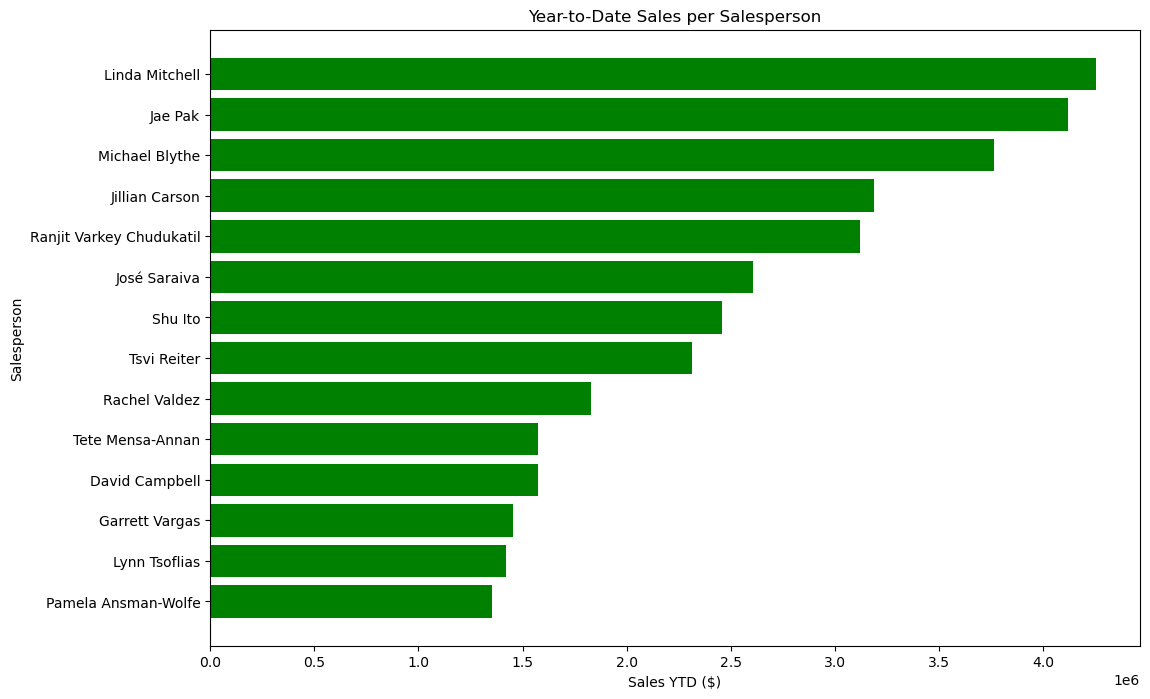

In [14]:
#Säljare och hur mycket de säljer med diagram
vSalesPerson = Table("vSalesPerson", metadata, autoload_with=engine, schema="Sales")

query = select(
    vSalesPerson.c.FirstName,
    vSalesPerson.c.LastName,
    cast(func.round(vSalesPerson.c.SalesYTD, 2), Float).label("Sales YTD") 
).where(
    vSalesPerson.c.TerritoryName.isnot(None),
    vSalesPerson.c.SalesYTD != 0
).order_by(vSalesPerson.c.SalesYTD.desc()) 

with engine.connect() as connection:
    result = connection.execute(query).fetchall()

data = [dict(row._mapping) for row in result] 

for row in data:
    row["Sales YTD"] = f"{row['Sales YTD']:,.0f}" 

print(tabulate(data, headers="keys", tablefmt="grid"))

salespeople = [f"{row['FirstName']} {row['LastName']}" for row in data]
sales_ytd = [float(row["Sales YTD"].replace(",", "")) for row in data] 

plt.figure(figsize=(12, 8))
plt.barh(salespeople, sales_ytd, color="green")
plt.xlabel("Sales YTD ($)")
plt.ylabel("Salesperson")
plt.title("Year-to-Date Sales per Salesperson")
plt.gca().invert_yaxis() 

plt.show()

In [15]:
#Kolla vilken produktkategori som det säljs mest av

metadata = MetaData()
metadata.reflect(bind=engine, schema="Sales")
metadata.reflect(bind=engine, schema="Production")

product = metadata.tables["Production.Product"]
product_subcategory = metadata.tables["Production.ProductSubcategory"]
product_category = metadata.tables["Production.ProductCategory"]
sales_order_detail = metadata.tables["Sales.SalesOrderDetail"] 

query = select(
    product_category.c.Name.label("Product Category"),
    func.sum(func.round(sales_order_detail.c.LineTotal, 2)).label("Total Sales"),
    func.sum(sales_order_detail.c.OrderQty).label("Total Quantity Sold")
).join(
    product, sales_order_detail.c.ProductID == product.c.ProductID
).join(
    product_subcategory, product.c.ProductSubcategoryID == product_subcategory.c.ProductSubcategoryID
).join(
    product_category, product_subcategory.c.ProductCategoryID == product_category.c.ProductCategoryID
).where(
    sales_order_detail.c.UnitPriceDiscount > 0
).group_by(
    product_category.c.Name
)

with engine.connect() as conn:
    result = conn.execute(query).fetchall()


data = [dict(row._mapping) for row in result]


print(tabulate(data, headers="keys", tablefmt="grid", floatfmt=".2f"))



C:\Users\jg3wi\AppData\Local\Temp\ipykernel_15120\4022246408.py:4: SAWarning: Did not recognize type 'hierarchyid' of column 'OrganizationNode'
  metadata.reflect(bind=engine, schema="Sales")
C:\Users\jg3wi\AppData\Local\Temp\ipykernel_15120\4022246408.py:4: SAWarning: Did not recognize type 'geography' of column 'SpatialLocation'
  metadata.reflect(bind=engine, schema="Sales")
C:\Users\jg3wi\AppData\Local\Temp\ipykernel_15120\4022246408.py:5: SAWarning: Did not recognize type 'hierarchyid' of column 'DocumentNode'
  metadata.reflect(bind=engine, schema="Production")


+--------------------+---------------+-----------------------+
| Product Category   |   Total Sales |   Total Quantity Sold |
+====================+===============+=======================+
| Clothing           |     479780.78 |                 18627 |
+--------------------+---------------+-----------------------+
| Bikes              |    4601049.01 |                  7526 |
+--------------------+---------------+-----------------------+
| Accessories        |     143811.43 |                  6586 |
+--------------------+---------------+-----------------------+
| Components         |     198050.52 |                  1080 |
+--------------------+---------------+-----------------------+


In [16]:
# Använder SQL-alchemy,scipy.stats och Numpy för att räkna ut priset på cyklar med ett 
# konfidensintervall på 95%

metadata.reflect(bind=engine, schema="Production")

product = metadata.tables["Production.Product"]
product_subcategory = metadata.tables["Production.ProductSubcategory"]
product_category = metadata.tables["Production.ProductCategory"]

query = select(
    func.avg(product.c.ListPrice).label("Average List Price"),
    func.stdev(product.c.ListPrice).label("Standard Deviation"),
    func.count().label("Sample Size")
).join(
    product_subcategory, product.c.ProductSubcategoryID == product_subcategory.c.ProductSubcategoryID
).join(
    product_category, product_subcategory.c.ProductCategoryID == product_category.c.ProductCategoryID
).where(
    product_category.c.Name == "Bikes",
    product.c.SellStartDate.between("2011-01-01", "2014-12-31")
)

with engine.connect() as conn:
    result = conn.execute(query).fetchone()

avg_price = float(result[0])
std_dev = float(result[1])
n = result[2]

confidence = 0.95
z_value = stats.norm.ppf((1 + confidence) / 2) 
margin_of_error = z_value * (std_dev / np.sqrt(n)) if n > 1 else 0 

ci_lower = avg_price - margin_of_error
ci_upper = avg_price + margin_of_error

data = [{
    "Average List Price": round(avg_price, 2),
    "Standard Deviation": round(std_dev, 2),
    "Sample Size": n,
    "95% CI Lower": round(ci_lower, 2),
    "95% CI Upper": round(ci_upper, 2)
}]

print(tabulate(data, headers="keys", tablefmt="grid"))



+----------------------+----------------------+---------------+----------------+----------------+
|   Average List Price |   Standard Deviation |   Sample Size |   95% CI Lower |   95% CI Upper |
+======================+======================+===============+================+================+
|              1586.74 |               996.27 |            97 |        1388.48 |           1785 |
+----------------------+----------------------+---------------+----------------+----------------+
